<strong>License</strong>: BSD<br/>
<strong>Copyright</strong>: Copyright The American Gut Project, 2014

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

In [2]:
# # This cell allows us to render the notebook in the way we wish no matter where
# # the notebook is rendered.
# from IPython.core.display import HTML
# css_file = '../ag.css'
# HTML(open(css_file, "r").read())

<a id="intro"></a>
___
*Note*: this notebook will likely require signifigant manual interaction is more intended to document exploratory analysis than to be adapted for other projects.
___

# [Title]

**[text about the topic goes here.]**

<a id="intro_sub1"></a>
## [Subsection 1]
**[Text about optional subsections.]**

<a href="#top">Return to the Table of Contents</a>

<a id="requirements"></a>
## Notebook Requirements
* [Python 2.7.3](https://www.python.org/download/releases/2.7/)
* [Numpy 1.9](http://www.numpy.org)
* [Qiime 1.9](https://www.qiime.org/install/install.html)
* [hdf5](http://www.hdfgroup.org/HDF5/) and [h5py](http://www.h5py.org). This is required to read the American Gut biom tables in Qiime.
* [Jinja2](http://jinja.pocoo.org/docs/dev/), [pyzmq](https://learning-0mq-with-pyzmq.readthedocs.org/en/latest/) and  [tornado](http://www.tornadoweb.org/en/stable/). These are required to open a local IPython notebook instance. hese are required to open a local ipython notebook on your machine. They are not automatically installed with iPython or Qiime.
* [Statsmodels 0.6.0](http://statsmodels.sourceforge.net)
* [American Gut Python Library](https://github.com/biocore/American-Gut)
* $\LaTeX$. [LiveTex](http://www.tug.org/texlive/) offers one installation solution.

<a id="top"></a>
##Table of contents
<ul><li><a href="#intro">Introduction</a>
<ul><li><a href="#intro_sub1">Subsection 1</a>
</li></ul>
</li><li><a href="#requirements">Notebook Requirements</a>
</li><li><a href="#imports">Function Import</a>
</li><li><a href="#params">Analysis parameters</a>
<ul><li><a href="#params_data">Dataset Selection</a>
</li><li><a href="#params_save">File Saving Parameters</a>
</li><li><a href="#params_text">Text File and Metadata Parameters</a>
</li><li><a href="#params_cat">Analysis Category Parameters</a>
</li><li><a href="#params_alpha">Alpha Diversity Parameters</a>
</li><li><a href="#params_beta">Beta Diversity Parameters</a>
</li><li><a href="#params_gs">Group Significance Parameters</a>
</li><li><a href="#params_figs">Plotting Parameters</a>
</li></ul>
</li><li><a href="#dir">Files and Directories</a>
<ul><li><a href="#dir_base">Base Directory</a>
</li><li><a href="#dir_data">Sample Directory and Files</a>
</li><li><a href="#dir_bdiv">Beta Diversity Analsysis Directories and Files</a>
</li><li><a href="#dir_gs">Group Significance Analysis Directories and Files</a>
</li><li><a href="#dir_image">Image Directories and Files</a>
</li></ul>
</li><li><a href="#download">Data Download</a>
</li><li><a href="#alpha">Alpha Diversity</a>
</li><li><a href="#beta">Beta Diversity</a>
</li><li><a href="#group">Group Significance</a>
</li><li><a href="#discussion">Discussion</a>
</li><li><a href="#refs">References</a>
</li></ul>

<a id="imports"></a>
## Function Import
We start by importing necessary functions, and determining if files should be overwritten.

In [3]:
import os
import shutil
import time

import scipy
import skbio
import biom
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sms
import statsmodels.formula.api as smf
import americangut.diversity_analysis as div

from matplotlib import rcParams

We will also set up some plotting parameters so the generated figures use Helvetica or Arial as their default font. For more on font properties, see the matplotlib documentation on [text objects](http://matplotlib.org/api/text_api.html?highlight=font#matplotlib.text.Text.set_fontproperties) and [rendering text with LaTex](http://matplotlib.org/users/pgf.html?highlight=font). We will also prompt the IPython notebook to display the images we generate live in the notebook.

In [4]:
# Displays images inline
%matplotlib inline

# Sets up plotting parameters so that the default setting is use to 
# Helvetica in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

<a href=#top>Return to the top</a>

<a id="params"></a>
## Analysis Parameters
We can also set some necessary parameters for handling files and this analysis. It’s easier to set them as a block, here, so that our systems are consistent than to modify each of the variables later in the import if our needs or our data changes.

<a id="params_data"></a>
### Dataset Selection
We will start by selecting which dataset we’d like to use for this analysis. We can select to work with the full OTU table or focus on a single body site. We can also choose which grouping of this data we’d like to use, limiting the analysis to a certain subset of the American Gut Population.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>site</strong><br>
(<code style="color:Firebrick;background-color:#D0D0D0">"all"</code>, 
<code style="color:Firebrick;background-color:#D0D0D0">"fecal"</code>, 
<code style="color:Firebrick;background-color:#D0D0D0">"oral"</code>, 
<code style="color:Firebrick;background-color:#D0D0D0">"skin"</code>)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            This identifies the bodysite where the analysis should be analyzed. It is recommended that categorical analysis focus on a single bodysite, since location on the human body has the largest effect on the microbial communities at those sites in relatively healthy adults and children four years of age and older [<a href="#22699611">22699611</a>; <a href="#22699609">22699609</a>].
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>dataset</strong><br>(
            <code style="color:Firebrick;background-color:#D0D0D0">""</code>,
            <code style="color:Firebrick;background-color:#D0D0D0">"all_participants_all_samples"</code>,
            <code style="color:Firebrick;background-color:#D0D0D0">"all_participants_one_sample"</code>,
            <code style="color:Firebrick;background-color:#D0D0D0">"sub_participants_all_samples"</code>,
            <code style="color:Firebrick;background-color:#D0D0D0">"sub_participants_one_sample"</code>)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p><strong><code>dataset</code></strong> identifies the subset of samples to be used 
            for analysis.</p> 
            <p>If the <strong><code>site</code></strong> is <code><font color="Firebrick">"all"</font></code>, the <strong><code>dataset</code></strong> should be <code><font color="Firebrick">""</font></code>. <br>
            There are not multiple subsets of samples avaliable for all data, if data was generated 
            through the preprocessing notebook.</p>
            <p>For site-specific analyses, every site has data for all participants and all 
            samples.
            Each individual’s microbiome is correlated with itself 
            [<a href="#21624126">21624126</a>, <a href="#21885731">21885731</a>], so to allow 
            multiple samples per individual violates an assumption of independence used in many statistical tests. Therefore, the 
            Preprocessing Notebook draws a single sample for each individual at each bodysite.</p>
            <p>We may also choose to work with a subset of the data. The preprocessing notebook 
            selects a healthy subset of adult participants. This includes individuals between 20 
            and 70 who have a BMI between 18.5 and 30. Additionally, these individuals cannot have 
            been diagnosed with IBD or diabetes and do not report using antibiotics in the past
            year.</p>
        </td>
    </tr>
</table>

In [5]:
site = 'fecal'
dataset = 'all_participants_one_sample'

<a id="params_save"></a>
### File Saving Parameters

In the course of this analysis, a series of files can be generated. The File Saving Parameters determine if new files are saved.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>overwrite</strong><br />(boolian)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>When <strong><code>overwrite</code></strong> is 
            <code><font color="228B22">True</font></code>, new files will
            be generated and saved during data processing. <br>It is 
            recommended that overwrite be set to 
            <code><font color="228B22">False</font></code>, in which case 
            new files will only be generated when the file does not exist. 
            This substantially decreases analysis time.</p>
            <p><strong><code>overwrite</code></strong> will also cause the 
            notebook to generate new post-hoc beta diversity comparisons, 
            even if the files exist. This can be computationally 
            expensive, and scales with the number of groups in a metadata 
            category and the number of samples.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>save_images</strong><br>(boolian)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            This notebook will generate images of the power curves. By 
            default, these will be displayed inside the notebook. However, 
            some users also find it advantageous to save the images.
            The file format can be set with the 
            <a href="#dir_analysis"><strong><code>image_pattern</code></strong></a>.
        </td>
    </tr>
</table>

In [6]:
overwrite = False
save_images = True

<a href="#top">Return to the top</a>

<a id="params_text"></a>
### Text File and Metadata Parameters
Qiime-formatted metadata and results files are frequently tab-separated text (.txt) files. These files can be opened in Excel or spreadsheet programs. You can learn more about Qiime mapping files [here](http://qiime.org/documentation/file_formats.html). We use the Pandas library to read most of our text files, which provides some spreadsheet like functionalities.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>txt_delim</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <strong><code>txt_delim</code></strong> specifies the way columns are separated in the files. Qiime typically consumes and produces tab-delimited (<code><font color="FireBrick">"\t"</font></code>) text files (.txt) for metadata and results generation.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
              <strong>map_index</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The name of the column containg the sample names. In Qiime, this column is called <code><font color="FireBrick">#SampleID</font></code>.
        </td>
    <tr>

    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>map_nas</strong><br />(list of strings)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            t is possible a mapping file map be missing values, since American Gut participants are free to skip any question. The pandas package is able to omit these missing samples from analysis. In raw American Gut files, missing values are typically denoted as <code><font color="FireBrick">“NA”</font></code>, <code><font color="FireBrick">“no_data”</font></code>, <code><font color="FireBrick">“unknown”</font></code>, and empty spaces (<code><font color="FireBrick">“”</font></code>).
        </td>
    <tr>

    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>write_na</strong><br /> (string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The value to denote missing values when text files are written from Pandas data frames. Using an empty space, (<code><font color="FireBrick">“”</font></code>) will allow certain Qiime scripts, like [group_signigance.py](http://qiime.org/scripts/group_significance.html), to ignore the missing values.
        </td>
    <tr>

    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>date_cols</strong><br /> (list of strings)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            Temporal data can be identified using the <strong><code>date_cols</code></strong>, allowing the Pandas program to do time-based analysis. In the American Gut dataset, there are four we identify initially: 
            <ul><li>*BIRTH_DATE*          (the participant’s birthdate)
            </li><li>*COLLECTION_DATE*    (the day the sample was collected)
            </li><li>*SAMPLE_TIME*        (the time the sample was collected)
            </li><li>*RUN_DATE*           (the day the samples were sequenced)
            </li></ul>
        </td>
    <tr>
</table>

In [7]:
# Sets parameters for file handling and reading tables
# into pandas
txt_delim = '\t'
map_index = '#SampleID'
map_nas = ['NA', 'no_data', 'unknown', '']
write_na = ''

<a href="#top">Return to the top</a>

<a id="params_alpha"></a>
### Alpha Diversity Parameters

<p>This notebook will compare alpha diversity and beta diversity for the category selected.  Alpha diversity is a comparison of intra-community variation. When alpha diversity values are compared, the comparison does not take into account the community structure. So, two communities which share no species can have the same alpha diversity. American Gut Analyses primarily focus on an alpha diversity metric called PD Whole Tree Diversity [<a herf="#15831718">15831718</a>]. PD Whole Tree is phylogenetically aware, meaning that it takes into account shared evolutionary history.</p>
<p>We will compare alpha diversity using a [kruskall-wallis test](http://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance), and we will plot the results as a [boxplot](http://en.wikipedia.org/wiki/Box_plot). We can set parameters for the way we make the comparison and how the figure will look.</p>


<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>a_div_metric</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>The alpha diversity metric to be used in the analysis. Mapping files generated by the Preprocessing Notebook have a set of mapping columns appended which provide the mean for several metrics. These are labeled as the metric name with <font color="firebrick"><code>“_mean”</code></font> appended to the end, to indicate the values are the mean of 10 rarefactions.</p>
<p>There are multiple alpha diversity metrics which can be used. The preprocessing notebook calculates four possible alpha diversity metrics for the data (PD Whole Tree Diversity [<a href="#15831718">15831718</a>], Shannon Diversity [<a href="#shannon">Shannon</a>], Chao1 diversity [<a href="#chao1">Chao</a>], and Observed Species diversity). The default value used here, <code><font color="Firebrick">“PD_whole_tree_mean”</font></code>, is the only metric which takes into account the evolutionary relationship between organisms in a sample.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>a_ylabel</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            This y-label appears on the boxplot to help clarify the information presented there. Alpha diversity is a unitless quantity.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>a_ylim</strong><br />(2 element list of numbers)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            This specifies the limits for the y axis. Limits should be set as a function of the diversity metric. With PD whole tree diversity, limits of <code>[5, 55]</code> is suggested. For shannon diversity, <code>[0, 8]</code> should be used as limits. Chao1 diversity has a larger range, and <code>[100, 1000]</code> can be used as limits. Observed Species also has a larger range, and <code>[0, 800]</code> may be an appropriate starting place.
        </td>
    </tr>
</table>


In [8]:
# Alpha Diversity Parameters
a_div_metric = 'PD_whole_tree_mean'
a_ylabel = 'PD Whole Tree Mean'
a_ylim = [5, 55]

<a href="#top">Return to the top</a>

<a id="params_beta"></a>
## Beta Diversity Parameters

Beta diversity looks at the difference in community structure across two communities. Each metric calculates a distance between the communities, which is reflective of their difference. American Gut Analyses have calculated weighted and unweighted UniFrac distance for the communities [<a href="#16332807">16332807</a>]. UniFrac distance takes into account the evolutionary relationship between samples, by determining what fraction of evolutionary history is different between two samples. Weighted UniFrac also takes into account the relative abundance of each taxa, while unweighted UniFrac distance only considers presence and absence. We will compare intra and intergroup UniFrac distances using permutation tests. We will plot the distance between samples as a bar chart. 

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>b_div_metric</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The beta diversity metric to be used in the analysis. This name will appear at the beginning of the distance matrix file.
        </td>
    </tr>
</table>

In [9]:
# Beta Diversity Parameters
b_div_metric = 'unweighted_unifrac'

## Regression Parameters

We'll start by setting up the parameters for our regression and providing several peices of information about the variables we'll be working with. [More text to be added laters...]

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>all_variables</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The names of any variables which will be used in the regression.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>continous_variables</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The names of any variables which will be used in the regression.
        </td>
    </tr>
</table>

In [10]:
all_variables = ['AGE', 'BMI', 'IBD', 'DIABETES', 'ANTIBIOTIC_SELECT', 
                 'ALCOHOL_FREQUENCY', 'TYPES_OF_PLANTS', 'COLLECTION_MONTH',
                 'EXERCISE_FREQUENCY', 'EXERCISE_LOCATION', 'SLEEP_DURATION',
                 'PD_whole_tree_mean', 'SEX', 'BMI_CAT']
response = 'PD_whole_tree_mean'

con_predictors = ['AGE', 'BMI']

cat_predictors = ['IBD', 'DIABETES', 'ANTIBIOTIC_SELECT', 
                  'ALCOHOL_FREQUENCY', 'TYPES_OF_PLANTS', 'COLLECTION_MONTH',
                  'EXERCISE_FREQUENCY', 'EXERCISE_LOCATION', 'SLEEP_DURATION',
                  'SEX', 'BMI_CAT']

We define our own categorization functions, rather than using the Patsy coding system, so we can pick our own reference varaibles. We are doing this in lou of using the [Patsy coding system](http://statsmodels.sourceforge.net/devel/contrasts.html), which is another option for handling categorical data.

In [11]:
def categorize_ibd(x):
    if x == 'I do not have IBD':
        return 0
    elif x in {"Ulcerative colitis", "Crohn's disease"}:
        return 1
    else:
        return np.nan

def categorize_diabetes(x):
    if x == 'I do not have diabetes':
        return 0
    elif x in {'Type I', 'Type II'}:
        return 1
    else:
        return np.nan

def categorize_antibiotics(x):
    if x == 'Not in the last year':
        return np.array([0, 0, 0])
    elif x in {'In the past week', 'In the past month'}:
        return np.array([1, 0, 0])
    elif x == 'In the past 6 months':
        return np.array([0, 1, 0])
    elif x == 'In the past year':
        return np.array([0, 0, 1])
    else:
        return np.array([np.nan]*3)
    
def categorize_frequency(x):
    if x == 'Never':
        return np.array([0, 0, 0, 0])
    elif x in {'Rarely', 'Rarely (few times/month)'}:
        return np.array([1, 0, 0, 0])
    elif x in {'Occasionally', 'Occasionally (1-2 times/week)'}:
        return np.array([0, 1, 0, 0])
    elif x in {'Regularly', 'Regularly (3-5 times/week)'}:
        return np.array([0, 0, 1, 0])
    elif x == 'Daily':
        return np.array([0, 0, 0, 1])
    else:
        return np.array([np.nan]*4)

def categorize_plants(x):
    if x == 'Less than 5':
        return np.array([0, 0, 0, 0])
    elif x == '6 to 10':
        return np.array([1, 0, 0, 0])
    elif x == '11 to 20':
        return np.array([0, 1, 0, 0])
    elif x in {'28', '21 to 30'}:
        return np.array([0, 0, 1, 0])
    elif x == 'More than 30':
        return np.array([0, 0, 0, 1])
    else:
        return np.array([np.nan]*4)
    

def descritize_month(x):
    try:
        t = time.strptime(x, '%B')
        return t.tm_mon
    except:
        return np.nan
    
def categorize_season(x):
    if x == 'Winter':
        return np.array([0, 0, 0])
    elif x == 'Spring':
        return np.array([1, 0, 0])
    elif x == 'Summer':
        return np.array([0, 1, 0])
    elif x == 'Fall':
        return np.array([0, 0, 1])
    else:
        return np.array([np.nan]*3)

def categorize_location(x):
    if x == 'Indoors':
        return np.array([0, 0, 0, 0])
    elif x == 'Outdoors':
        return np.array([1, 0, 0, 0])
    elif x == 'Depends on the Season':
        return np.array([0, 1, 0, 0])
    elif x == 'Both':
        return np.array([0, 0, 1, 0])
    elif x == 'None of the above':
        return np.array([0, 0, 0, 1])
    else:
        return np.array([np.nan]*4)

def categorize_sleep(x):
    if x == 'Less than 6 hours':
        return np.array([0, 0, 0])
    elif x == '6-7 hours':
        return np.array([1, 0, 0])
    elif x == '7-8 hours':
        return np.array([0, 1, 0])
    elif x == '8 or more hours':
        return np.array([0, 0, 1])
    else:
        return np.array([np.nan]*3)
    
def categorize_sex(x):
    if x == 'female':
        return np.array([0, 0])
    elif x == 'male':
        return np.array([1, 0])
    else:
        return np.array([np.nan, np.nan])

def categorize_bmi(x):
    if x == 'Normal':
        return np.array([0, 0, 0])
    elif x == "Underweight":
        return np.array([1, 0, 0])
    elif x == 'Overweight':
        return np.array([0, 1, 0])
    elif x == 'Obese':
        return np.array([0, 0, 1])
    else:
        return np.array([np.nan]*3)

Now, we'll create a dictory of categorical variables, mapping the variable to its conversion function and the column names when converted.

In [13]:
conversion = {'IBD': (['IBD_case'], categorize_ibd),
              'DIABETES': (['DIABETES_case'], categorize_diabetes),
              'ANTIBIOTIC_SELECT': (['ABX_past_month', 'ABX_past_6_months', 'ABX_past_year'], categorize_antibiotics),
              'TYPES_OF_PLANTS': (['PLANTS_6_10', 'PLANTS_11_20', 'PLANTS_21_30', 'PLANTS_30+'], categorize_plants),
              'EXERCISE_LOCATION': (['EX_LOC_out', 'EX_LOC_depends', 'EX_LOC_both', 'EX_LOC_none'], categorize_location),
              'SLEEP_DURATION': (['SLEEP_6', 'SLEEP_7', 'SLEEP_8'], categorize_sleep),
              'SEX': (['SEX_m', 'SEX_o'], categorize_sex),
              'BMI_CAT': (['BMI_under', 'BMI_over', 'BMI_obese'], categorize_bmi),
              'COLLECTION_MONTH': (['COLLECTION_MONTH_desc'], descritize_month),
              'COLLECTION_SEASON': (['SEASON_spring', 'SEASON_summer', 'SEASON_fall'], categorize_season),
              'EXERCISE_FREQUENCY': (['EX_FREQ_rare', 'EX_FREQ_occ', 'EX_FREQ_regular', 'EX_FREQ_daily'], categorize_frequency),
              'ALCOHOL_FREQUENCY': (['ETOH_FREQ_rare', 'ETOH_FREQ_occ', 'ETOH_regular', 'ETOH_FREQ_daily'], categorize_frequency)
              }

<a href="#top">Return to the top</a>

<a id="dir"></a>
## Files and Directories

We need to import working OUT data for analysis and set up a location where results from our analysis can be saved. This notebook consumes pre-processed tables (OTU tables, mapping files and distance matrices) produced by the Preprocessing Notebook. These can be downloaded individually, or the whole set is available [here](https://www.dropbox.com/s/q7wrf4tme2mrt0p/all_samples.tgz).

As we set up directories, we’ll make use the of the **check_dir** function. This will create the directories we identify if they do not exist.

<a id="dir_base"></a>

### Base Directory

We need a general location to do all our analysis; this is the base_dir. All our other directories will exist within the **$base_dir$**, and allow us to work. The working directory is a directory within the base directory where we’ll find the files we need.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>base_dir</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The filepath for the directory where any files associated with the analysis should be saved. It is suggested this be a directory called <strong>agp_analysis</strong>, and be located in the same directory as the IPython notebooks.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>working_dir</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The file path for the directory where all data files associated with this analysis have been stored. This should contain the results of the Preprocessing Notebook.<br>
The working_dir is expected to be a directory called <strong>sample_data</strong> in the <strong><code>base_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>analysis_dir</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The file path where analysis results should be stored. This is expected to be a folder in the <strong><code>base_dir</code></strong>.
        </td>
    </tr>
</table>

In [14]:
# Sets up the base directory
# base_dir = os.path.join(os.path.abspath('.'), 'agp_analysis')
base_dir = '/Users/jwdebelius/Desktop/agp_analysis'
div.check_dir(base_dir)

# Sets up data directory
working_dir = os.path.join(base_dir, 'sample_data')
div.check_dir(working_dir)

# Sets up the analysis directory
analysis_dir = os.path.join(base_dir, 'analysis_results')
div.check_dir(analysis_dir)

<a href="#top">Return to the top</a>
<a id="dir_data"></a>
### Sample Directory and Files

We’ll focus our analysis on fecal samples, which we set with the <a href="#params_data"><strong><code>site</code></strong></a> variable. We’ve chosen to focus on a single sample from a healthy subset of adults in the American Gut population (set with the <strong><code><a href="#params_data">dataset</a></code></strong> variable). To be included in this group, a sample must come from a donor between the ages of 20 and 69 (inclusive) who has a BMI between 18.5 and 30 and does not report having IBD or diabetes.  
Our analysis will use a mapping file, OTU table and unweighted UniFrac distance matrix.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>site_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The filepath for the directory where data sets from fecal samples are stored. This should be a directory in the <strong><code>working_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>data_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The filepath of the subset participants single sample directory. This should be a folder in the <strong><code>site_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>data_map_fp</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>This specifies the filepath for the metadata file associated with the fecal samples. This should be a text file (.txt) in the <strong><code>data_dir</code></strong>.</p>
<p>A mapping file allows us to relate information about the sample to information about the microbiome. This contains a barcode used to identify each sample, and information about the participants from the survey, such as age, diet, or disease status. This cannot be used identify participants and does not contain data like names, physical or email addresses. In the rarefied mapping file (the filenames contain even10k), the mapping file also contains alpha diversity results for each sample. </p>
<p>The notebook expects the metadata to be processed through the Preprocessing notebook, which involved converting continuous categories to categorical data. The rarefied file (<code>AGP_100nt_even10k…</code>), which contains alpha diversity results, is required.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>data_otu_fp</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
<p>The filepath for the otu table file associated with the fecal samples. This should be a <a href="http://www.biom-format.org">biom-format</a> file (.biom) in the <strong><code>data_dir</code></strong> [<a href="#23587224">23587224</a>].</p>
<p>The OTU table is assumed to be rarefied to an even depth. This is designated in the filename with the phrase, “even10k”, indicating the OTU table has been rarefied to 10,000 sequences per sample.</p>
<p>An OTU table gives the bacterial counts in each sample. An OTU, or operational taxonomic unit, is technically a cluster of sequence at a certain level of similarity. We use sequence clustering to account for PCR and read error. The level of similarity used here, 97% gives approximately genus level resolution [<a href="#17586664">17586664</a>]. Multiple OTUs may map to a single bacterial taxa.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>data_bdiv_fp</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>The filepath for the unweighted UniFrac distance matrix file associated with the fecal samples. This should be a text file (.txt) in the <strong><code>data_dir</code></strong>.</p>
The distance matrix relates the microbiome composition in each sample community to every other community. Unweighted UniFrac distance considers shared evolutionary history and the presence or absence of OTUs in this calculation [<a href="#16332807">16332807</a>]. Identical communities have a UniFrac Distance of 0, while communities which have no shared history have a UniFrac distance of 1.
        </td>
    </tr>
</table>

In [15]:
# Sets up OTU path directories
site_dir = os.path.join(working_dir, site)
div.check_dir(site_dir)

data_dir = os.path.join(site_dir, dataset)

# Sets the subset filepath for all samples
data_otu_fp = os.path.join(data_dir, 'AGP_100nt_even10k_fecal.biom')
data_map_fp = os.path.join(data_dir, 'AGP_100nt_even10k_fecal.txt')
data_ubd_fp = os.path.join(data_dir, '%s_AGP_100nt_even10k_fecal.txt') % b_div_metric

<a href="#top">Return to the top</a>
<a id="dir_image"></a>
### Image Directories and Files

We can save the graphical results of our analysis, in addition to displaying them in the notebook. We will use a file structure similar to the way we’ve saved our OTU tables to keep track of the images generated.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>image_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The parent directory for the images generated by the notebook. This expected to be a directory in the <strong><code>analysis_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>site_image_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
A body-site specific directory for the result images. This is expected to be a directory in the <strong><code>image_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>data_image_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The directory for the specific dataset used in the analysis. For example, a comparison based on age could be performed on a single sample per participant among the healthy subset of adults (one_sample_sub_participants) and a single sample per participant for all participants (one_sample_all_participants) to see if the trends seen in the healthy subset hold true as the data set expands.
This is expected to be a directory in <strong><code>image_site_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>image_pattern</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The filename to be used for saving results images we generate. This uses file replacement. We can generate a dictionary object where we identify the value that will fill in the blanks. The code, <code><font color="Firebrick">"%s"</font></code> allows a string.
        </td>
    </tr>
</table>

In [16]:
image_dir = os.path.join(analysis_dir, 'images')
div.check_dir(image_dir)

site_image_dir = os.path.join(image_dir, site)
div.check_dir(site_image_dir)

data_image_dir = os.path.join(site_image_dir, dataset)
div.check_dir(data_image_dir)

image_pattern = os.path.join(data_image_dir, '%(div_metric)s_%(image_type)s_%(category)s.png')

<a href="#top">Return to the top</a>
<a id="download"></a>
## Data Download

We will start our analysis using the clean, rarefied tables generated by the Preprocessing Notebook. If necessary, these files can be downloaded. The necessary files are then loaded into the notebook for analysis and processing.

In [17]:
# Loads the files into the notebook
data_otu = biom.load_table(data_otu_fp)
data_map = pd.read_csv(data_map_fp,
                       sep=txt_delim, 
                       na_values=map_nas,
                       index_col=False)
data_map.index = data_map[map_index]
del data_map[map_index]
data_ubd = skbio.DistanceMatrix.read(data_ubd_fp)

# Function definations

# Metadata Conversion and Massage

We'll start by creating a dataframe that will look at only the prediction and response variables. We'll use this to re-code the response variables for the regression. There are several discussion of this approach which I should probably cite at some point...

In [18]:
data_in = data_map[con_predictors]
data_in = data_in.join(data_map[response])

for cat, (columns, f) in conversion.iteritems():
    # Checks we should operate on this category
    if cat not in cat_predictors:
        continue
    descrete = pd.DataFrame(data=np.vstack(data_map[cat].apply(f).values),
                            index=data_map.index, columns=columns)
    data_in = data_in.join(descrete)

data_in['COLLECTION_MONTH_cos'] = data_in.COLLECTION_MONTH_desc.apply(lambda x: np.pi*x/6.)

Now, we'll remove any lines which contain undefined variables, so our regression looks only at defined data.

In [19]:
data_in = data_in.dropna()

# Regression with Season

Finally, we'll indentify an initial predictor and response variable. I'd like to try using `COLLECTION_MONTH` as the first variable. So, if we call our PD whole tree diversity, $y$, then we are evaluating the following relationship:

$$y = \beta_{0} + \beta_{month}*(MONTH) + \epsilon \tag{r1}$$

We will solve for the intercept, $\beta_{0}$, and the linear coeffecient for age, $\beta_{age}$. Our residuals will represent the error term, $\epsilon$.

In [20]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in['COLLECTION_MONTH_desc'])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5117
Date:                Wed, 08 Apr 2015   Prob (F-statistic):              0.475
Time:                        10:58:09   Log-Likelihood:                -4449.7
No. Observations:                1385   AIC:                             8903.
Df Residuals:                    1383   BIC:                             8914.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                    30.86

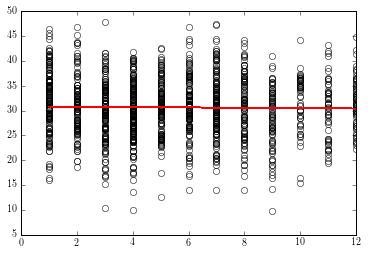

In [23]:
ax = plt.axes()
ax.plot(data_in['COLLECTION_MONTH_desc'], data_in[response], 'o', mfc='none', mec='k')
ax.plot(data_in['COLLECTION_MONTH_desc'], ori_results.fittedvalues, 'r-')

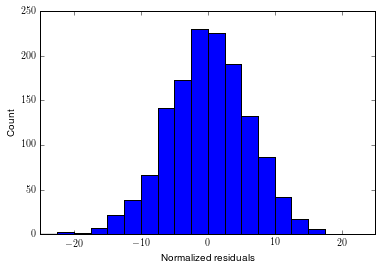

In [24]:

plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

In [85]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     30.32
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           1.30e-13
Time:                        01:52:23   Log-Likelihood:                -4420.3
No. Observations:                1385   AIC:                             8847.
Df Residuals:                    1382   BIC:                             8862.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         29.2303      0.780     37.451      0.0

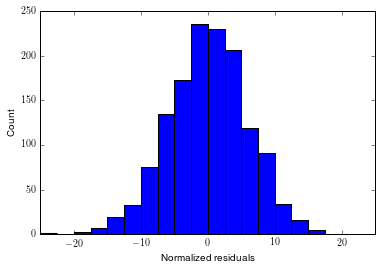

In [86]:

plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

In [87]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     20.21
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           8.02e-13
Time:                        01:52:25   Log-Likelihood:                -4420.2
No. Observations:                1385   AIC:                             8848.
Df Residuals:                    1381   BIC:                             8869.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         29.2576      0.790     37.043      0.0

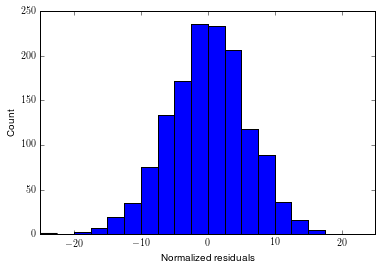

In [88]:
plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

In [89]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     25.53
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           1.98e-20
Time:                        01:52:27   Log-Likelihood:                -4400.6
No. Observations:                1385   AIC:                             8811.
Df Residuals:                    1380   BIC:                             8837.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         29.7576      0.783     38.004      0.0

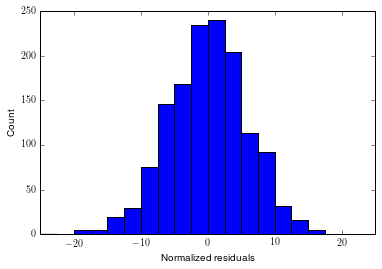

In [90]:
plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

In [91]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case', 'diabetes_case']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     21.23
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           1.65e-20
Time:                        01:52:28   Log-Likelihood:                -4398.6
No. Observations:                1385   AIC:                             8809.
Df Residuals:                    1379   BIC:                             8841.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            29.6388      0.785     37.779

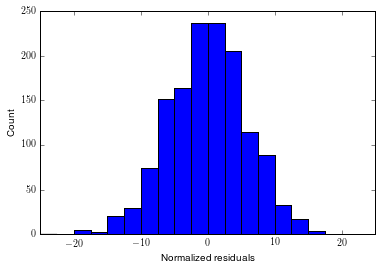

In [92]:
plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

In [93]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case', 'diabetes_case',
                              'ABX_past_month', 'ABX_past_6_months', 'ABX_past_year']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     18.82
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           5.16e-27
Time:                        01:52:30   Log-Likelihood:                -4378.1
No. Observations:                1385   AIC:                             8774.
Df Residuals:                    1376   BIC:                             8821.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                29.8714      0.77

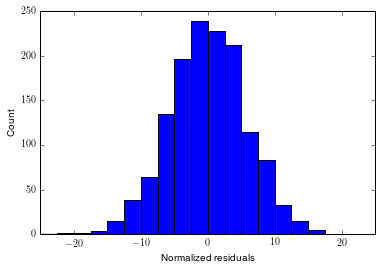

In [94]:
plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     21.15
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           3.37e-27
Time:                        01:52:31   Log-Likelihood:                -4379.3
No. Observations:                1385   AIC:                             8775.
Df Residuals:                    1377   BIC:                             8816.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                29.9648      0.77

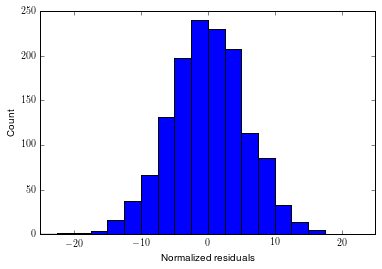

In [95]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case',
                              'ABX_past_month', 'ABX_past_6_months', 'ABX_past_year']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     15.41
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           1.13e-28
Time:                        01:52:31   Log-Likelihood:                -4369.4
No. Observations:                1385   AIC:                             8763.
Df Residuals:                    1373   BIC:                             8826.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                27.9222      0.94

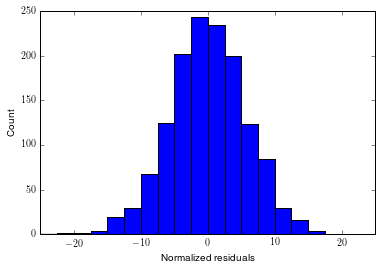

In [96]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case',
                              'ABX_past_month', 'ABX_past_6_months', 'ABX_past_year',
                              'PLANTS_6_10', 'PLANTS_11_20', 'PLANTS_21_30', 'PLANTS_30+']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     12.97
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           3.81e-29
Time:                        01:52:32   Log-Likelihood:                -4363.8
No. Observations:                1385   AIC:                             8758.
Df Residuals:                    1370   BIC:                             8836.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                26.2038      1.09

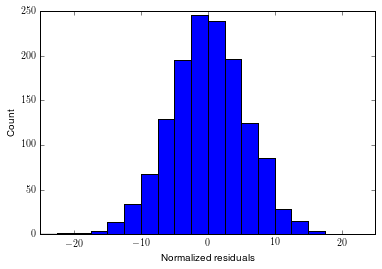

In [97]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case',
                              'ABX_past_month', 'ABX_past_6_months', 'ABX_past_year',
                              'PLANTS_6_10', 'PLANTS_11_20', 'PLANTS_21_30', 'PLANTS_30+',
                              'SLEEP_6', 'SLEEP_7', 'SLEEP_8']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     12.38
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           2.93e-34
Time:                        01:52:33   Log-Likelihood:                -4345.3
No. Observations:                1385   AIC:                             8729.
Df Residuals:                    1366   BIC:                             8828.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                25.6873      1.08

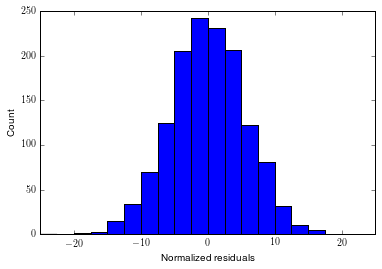

In [98]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case',
                              'ABX_past_month', 'ABX_past_6_months', 'ABX_past_year',
                              'PLANTS_6_10', 'PLANTS_11_20', 'PLANTS_21_30', 'PLANTS_30+',
                              'SLEEP_6', 'SLEEP_7', 'SLEEP_8',
                              'ETOH_FREQ_rare', 'ETOH_FREQ_occ', 'ETOH_regular', 'ETOH_FREQ_daily']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     11.36
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           8.13e-37
Time:                        01:52:33   Log-Likelihood:                -4333.3
No. Observations:                1385   AIC:                             8713.
Df Residuals:                    1362   BIC:                             8833.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                22.0190      1.49

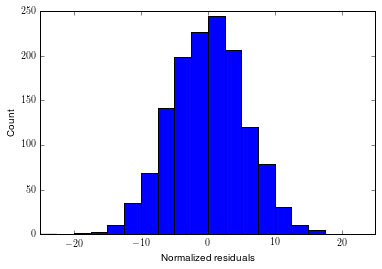

In [99]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case',
                              'ABX_past_month', 'ABX_past_6_months', 'ABX_past_year',
                              'PLANTS_6_10', 'PLANTS_11_20', 'PLANTS_21_30', 'PLANTS_30+',
                              'SLEEP_6', 'SLEEP_7', 'SLEEP_8',
                              'ETOH_FREQ_rare', 'ETOH_FREQ_occ', 'ETOH_regular', 'ETOH_FREQ_daily',
                              'EX_FREQ_rare', 'EX_FREQ_occ', 'EX_FREQ_regular', 'EX_FREQ_daily']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1596.
Date:                Wed, 08 Apr 2015   Prob (F-statistic):               0.00
Time:                        01:52:34   Log-Likelihood:                -4368.9
No. Observations:                1385   AIC:                             8788.
Df Residuals:                    1360   BIC:                             8919.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
AGE                   0.0668      0.01

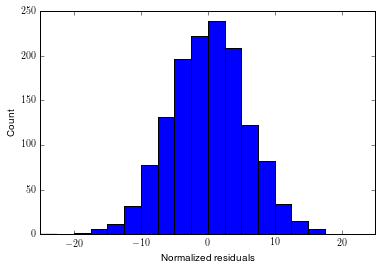

In [100]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case',
                              'ABX_past_month', 'ABX_past_6_months', 'ABX_past_year',
                              'PLANTS_6_10', 'PLANTS_11_20', 'PLANTS_21_30', 'PLANTS_30+',
                              'SLEEP_6', 'SLEEP_7', 'SLEEP_8',
                              'ETOH_FREQ_rare', 'ETOH_FREQ_occ', 'ETOH_regular', 'ETOH_FREQ_daily',
                              'EX_FREQ_rare', 'EX_FREQ_occ', 'EX_FREQ_regular', 'EX_FREQ_daily',
                              'EX_LOC_out', 'EX_LOC_depends', 'EX_LOC_both', 'EX_LOC_none']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     11.36
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           8.13e-37
Time:                        01:52:35   Log-Likelihood:                -4333.3
No. Observations:                1385   AIC:                             8713.
Df Residuals:                    1362   BIC:                             8833.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                22.0190      1.49

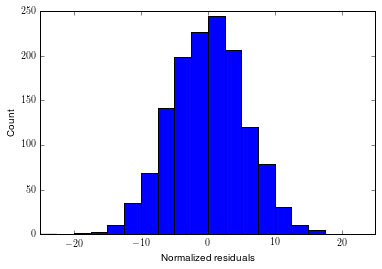

In [101]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case',
                              'ABX_past_month', 'ABX_past_6_months', 'ABX_past_year',
                              'PLANTS_6_10', 'PLANTS_11_20', 'PLANTS_21_30', 'PLANTS_30+',
                              'SLEEP_6', 'SLEEP_7', 'SLEEP_8',
                              'ETOH_FREQ_rare', 'ETOH_FREQ_occ', 'ETOH_regular', 'ETOH_FREQ_daily',
                              'EX_FREQ_rare', 'EX_FREQ_occ', 'EX_FREQ_regular', 'EX_FREQ_daily']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

In [102]:
data_in.columns

Index([u'AGE', u'BMI', u'PD_whole_tree_mean', u'COLLECTION_MONTH_desc', u'ibd_case', u'BMI_under', u'BMI_over', u'BMI_obese', u'ETOH_FREQ_rare', u'ETOH_FREQ_occ', u'ETOH_regular', u'ETOH_FREQ_daily', u'ABX_past_month', u'ABX_past_6_months', u'ABX_past_year', u'EX_FREQ_rare', u'EX_FREQ_occ', u'EX_FREQ_regular', u'EX_FREQ_daily', u'PLANTS_6_10', u'PLANTS_11_20', u'PLANTS_21_30', u'PLANTS_30+', u'diabetes_case', u'EX_LOC_out', u'EX_LOC_depends', u'EX_LOC_both', u'EX_LOC_none', u'SEX_m', u'SEX_o', u'SLEEP_6', u'SLEEP_7', u'SLEEP_8', u'COLLECTION_MONTH_cos'], dtype='object')

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     10.87
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           2.65e-36
Time:                        01:52:57   Log-Likelihood:                -4333.2
No. Observations:                1385   AIC:                             8714.
Df Residuals:                    1361   BIC:                             8840.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                    22.08

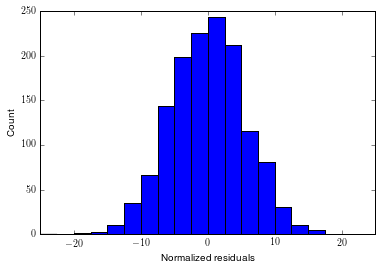

In [103]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case',
                              'ABX_past_month', 'ABX_past_6_months', 'ABX_past_year',
                              'PLANTS_6_10', 'PLANTS_11_20', 'PLANTS_21_30', 'PLANTS_30+',
                              'SLEEP_6', 'SLEEP_7', 'SLEEP_8',
                              'ETOH_FREQ_rare', 'ETOH_FREQ_occ', 'ETOH_regular', 'ETOH_FREQ_daily',
                              'EX_FREQ_rare', 'EX_FREQ_occ', 'EX_FREQ_regular', 'EX_FREQ_daily', 
                              'COLLECTION_MONTH_desc']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

                            OLS Regression Results                            
Dep. Variable:     PD_whole_tree_mean   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     10.87
Date:                Wed, 08 Apr 2015   Prob (F-statistic):           2.65e-36
Time:                        01:53:14   Log-Likelihood:                -4333.2
No. Observations:                1385   AIC:                             8714.
Df Residuals:                    1361   BIC:                             8840.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                   22.0870 

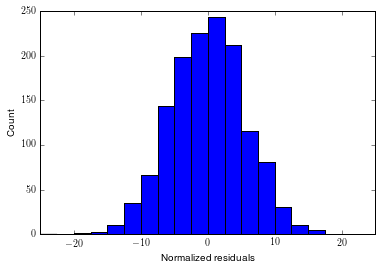

In [104]:
# Gets predictor and responses
y = data_in[response]
X = sms.add_constant(data_in[['AGE', 'BMI', 'SEX_m', 'ibd_case',
                              'ABX_past_month', 'ABX_past_6_months', 'ABX_past_year',
                              'PLANTS_6_10', 'PLANTS_11_20', 'PLANTS_21_30', 'PLANTS_30+',
                              'SLEEP_6', 'SLEEP_7', 'SLEEP_8',
                              'ETOH_FREQ_rare', 'ETOH_FREQ_occ', 'ETOH_regular', 'ETOH_FREQ_daily',
                              'EX_FREQ_rare', 'EX_FREQ_occ', 'EX_FREQ_regular', 'EX_FREQ_daily', 
                              'COLLECTION_MONTH_cos']])

# Solves the regression
ori_model = sms.OLS(y, X, **{})
ori_results = ori_model.fit()
print ori_results.summary()

plt.hist(ori_results.resid, bins=np.arange(-25, 25, 2.5))
plt.xlim([-25, 25])
plt.ylabel('Count')
plt.xlabel('Normalized residuals')